In [1]:
#import the ML libraries and keras API
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.callbacks import TensorBoard
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout, Lambda, InputLayer

Using TensorFlow backend.


In [2]:
#tensorflow ML framework by google
import tensorflow as tf
from tensorflow.python.framework import graph_util
import cv2

In [3]:
#data visualization libraries and other tools
#import matplotlib.pyplot as plt
import os
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [4]:
tf.__version__

'1.12.0'

In [5]:
#The directory of the datasets
train_path  = "C:/Users/Dickens/Documents/images/project/train"
validation_path = "C:/Users/Dickens/Documents/images/project/validation"
test_path = "C:/Users/Dickens/Documents/images/project/test/"

In [6]:
#generate the images using keras ImageDataGenerator
IMAGE_SIZE = 128
train_images = ImageDataGenerator().flow_from_directory(train_path,
                                                    target_size=(IMAGE_SIZE ,IMAGE_SIZE),
                                                    classes=['Gray Leaf Spot','Healthy','Maize Common Smut','Maize Streak Virus','Northern Leaf Blight'],
                                                    batch_size=10,
                                                    class_mode='categorical')
    
validation_images = ImageDataGenerator().flow_from_directory(validation_path,
                                                    target_size=(IMAGE_SIZE ,IMAGE_SIZE),
                                                    classes=['Gray Leaf Spot','Healthy','Maize Common Smut','Maize Streak Virus','Northern Leaf Blight'],
                                                    batch_size=10,
                                                    class_mode='categorical')

test_images = ImageDataGenerator().flow_from_directory(test_path,
                                                    target_size=(IMAGE_SIZE ,IMAGE_SIZE),
                                                    classes=['Gray Leaf Spot','Healthy','Maize Common Smut','Maize Streak Virus','Northern Leaf Blight'],
                                                    batch_size=10, 
                                                    class_mode='categorical')

Found 1673 images belonging to 5 classes.
Found 1666 images belonging to 5 classes.
Found 1666 images belonging to 5 classes.


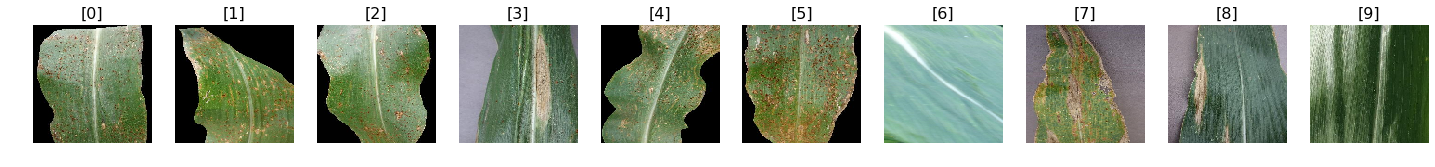

In [7]:
#plot the images with labels with matplotlib
def plot(ims, figsize=(25,25),rows=1, interp=False, titles= None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
        f = plt.figure(figsize= figsize)
        cols = len(ims) // rows if len(ims) %2 ==0 else len(ims) // rows + 1
        for i  in range(len(ims)):
            sp = f.add_subplot(rows, cols, i + 1)
            sp.axis('Off')
            if titles is not None:
                sp.set_title([i], fontsize=16)
            plt.imshow(ims[i], interpolation= None if interp else 'none')

imgs, labels = next(train_images)
plot(imgs, titles = labels)
    

In [8]:
train_images.class_indices

{'Gray Leaf Spot': 0,
 'Healthy': 1,
 'Maize Common Smut': 2,
 'Maize Streak Virus': 3,
 'Northern Leaf Blight': 4}

In [21]:
#build the model
def build_classification_model(is_training = True):
    model = Sequential()
    model.add(Conv2D(64,(3,3),
                     padding='same',
                     input_shape=(128,128,3),
                     name='maize_disease_classifier'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2, name='pool_1'))
    
    model.add(Conv2D(128,(3,3),name='conv_2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2, name='pool_2'))
    
    model.add(Conv2D(256,(3,3), name='conv_3'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2, name='pool_3'))
    
    model.add(Conv2D(512,(3,3), name='conv_4'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2, name='pool_4'))
    
    model.add(Flatten())
    model.add(Dense(512, name='full_con_layer_1'))
    model.add(Activation('relu'))
    
    if(is_training):
        model.add(Lambda(lambda x:K.dropout(x, level=0.5), name='drop_out_layer_1'))
    model.add(Dense(5,name='full_con_layer_2'))
    model.add(Activation('softmax', name='class_results'))
    
    
    return model

In [22]:
model = build_classification_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
maize_disease_classifier (Co (None, 128, 128, 64)      1792      
_________________________________________________________________
activation_5 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 64, 64, 64)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 62, 62, 128)       73856     
_________________________________________________________________
activation_6 (Activation)    (None, 62, 62, 128)       0         
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 31, 31, 128)       0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 29, 29, 256)       295168    
__________

In [23]:
#train the model and save its weights and parameters
tf.reset_default_graph()
sess = tf.Session() #start a tensorflow session 
#sess.run(tf.global_variables_initializer())
K.set_session(sess)

batch_size = 26
num_epochs = 60
model = build_classification_model()
model.compile(loss='categorical_crossentropy',
             optimizer = 'adam',
             metrics =['accuracy'])


In [24]:
#model.fit(train_images, test_images,validation_split=0.3, batch_size = batch_size, epochs=num_epochs, shuffle=True)

In [25]:
#perform data augmentation to generate new images from the exissting ones
IMAGE_TARGET_SIZE = 128
train_datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path,
                                                   target_size=(IMAGE_TARGET_SIZE,IMAGE_TARGET_SIZE),
                                                   batch_size=batch_size,
                                                   classes=['Gray Leaf Spot','Healthy','Maize Common Smut','Maize Streak Virus','Northern Leaf Blight'],
                                                   class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_path,
                                                       target_size=(IMAGE_TARGET_SIZE,IMAGE_TARGET_SIZE),
                                                       batch_size=batch_size,
                                                       classes=['Gray Leaf Spot','Healthy','Maize Common Smut','Maize Streak Virus','Northern Leaf Blight'],
                                                       class_mode='categorical')

Found 1673 images belonging to 5 classes.
Found 1666 images belonging to 5 classes.


In [26]:
#create a keras callbacks to save the parameters during the training
class TFCheckpointCallback(keras.callbacks.Callback):
    def __init__(self, saver, sess):
        self.saver = saver
        self.sess  = sess
        
    #a callback that is called at the end of each epoch and saves the parameters
    def on_epoch_end(self, epoch, logs =None):
        self.saver.save(self.sess, 'freeze/checkpoints',global_step= 5)
    
        
#create an instance of the tensorflow saver and use it to set up the callback
tf_saver = tf.train.Saver(max_to_keep = 5)
checkpoint_callback = TFCheckpointCallback(tf_saver, sess)
    

In [27]:
#save the model in human readable format using the tensorflow session instance
tf_graph = sess.graph
tf.train.write_graph(tf_graph.as_graph_def(), 'freeze','graph.pbtxt', as_text=True)
#tf.io.write_graph(tf_graph, 'freeze','graph.pbtxt',as_text=True)
tensor_callback = TensorBoard('freeze/logs/tensorboard-visualizer') #instantiate the tensorboard callback

In [28]:
train_datagen

In [29]:
#train the model by supplying the trainig parameters

model.fit_generator(train_generator,
                    steps_per_epoch = batch_size,
                    epochs = num_epochs,
                    callbacks = [checkpoint_callback, tensor_callback],
                    validation_data=validation_generator,
                    validation_steps=batch_size,
                    shuffle=True,
                    verbose=1)

sess.close()

Epoch 1/60
26/26 [==============================] - 132s 5s/step - loss: 1.1547 - acc: 0.4956 - val_loss: 0.8708 - val_acc: 0.6331
Epoch 2/60
26/26 [==============================] - 130s 5s/step - loss: 0.8360 - acc: 0.6329 - val_loss: 1.1690 - val_acc: 0.5015
Epoch 3/60
26/26 [==============================] - 132s 5s/step - loss: 0.8444 - acc: 0.6109 - val_loss: 0.7759 - val_acc: 0.6553
Epoch 4/60
26/26 [==============================] - 130s 5s/step - loss: 0.8106 - acc: 0.6076 - val_loss: 0.8031 - val_acc: 0.6154
Epoch 5/60
26/26 [==============================] - 133s 5s/step - loss: 0.7837 - acc: 0.6213 - val_loss: 0.7185 - val_acc: 0.6834
Epoch 6/60
26/26 [==============================] - 135s 5s/step - loss: 0.7513 - acc: 0.7027 - val_loss: 0.6322 - val_acc: 0.7870
Epoch 7/60
26/26 [==============================] - 133s 5s/step - loss: 0.6472 - acc: 0.7323 - val_loss: 0.6755 - val_acc: 0.6701
Epoch 8/60
26/26 [==============================] - 136s 5s/step - loss: 0.6244 - a

In [30]:
#prepare the graph for freezing before the actual freezing of the model
def prepare_model_graph_for_freezing(model_folder):
    model = build_classification_model()
    checkpoint = tf.train.get_checkpoint_state(model_folder)
    input_checkpoint = checkpoint.model_checkpoint_path
    saver = tf.train.Saver()
    with tf.Session(config=tf.ConfigProto(allow_soft_placement= True)) as sess:
        K.set_session(sess)
        saver.restore(sess,input_checkpoint)
        tf.gfile.MakeDirs(model_folder+'freeze')
        saver.save(sess,model_folder+'freeze/checkpoint',global_step=0)
        
#freeze the model graph
def freeze_graph(model_folder):
    checkpoint = tf.train.get_checkpoint_state(model_folder)
    print(model_folder+'freeze/')
    input_checkpoint = checkpoint.model_checkpoint_path
    absolute_model_folder = "/".join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_folder+"/frozen_model.pb"
    
    #tell tensorflow which nodes are used as ouput before the freezing
    output_node_names = "class_results/Softmax"
    
    #incase the model is trained on a GPU ensre that there are no GPU directives on the graph
    clear_devices = True
    new_saver = tf.train.import_meta_graph(input_checkpoint + '.meta',clear_devices = clear_devices)
    
    #retreive the created protobuf definion of the graph
    graph = tf.get_default_graph()
    input_graph_def = graph.as_graph_def()
    with tf.Session(config = tf.ConfigProto(allow_soft_placement= True)) as sess_2:
        print(input_checkpoint)
        new_saver.restore(sess_2, input_checkpoint)
        #convert all the possible trainable variables to constants
        output_graph_def = graph_util.convert_variables_to_constants(sess_2,#use the session to erstore the weights
                                                                    input_graph_def,#use the graph's definion to restore nodes
                                                                    output_node_names.split(',')#select the useful nodes
                                                                    )
        
        #freeze the graph and save it
        with tf.gfile.GFile(output_graph,"wb") as f:
            f.write(output_graph_def.SerializeToString())
        print("%d operations in the final graph."%len(output_graph_def.node))
        
tf.reset_default_graph()
prepare_model_graph_for_freezing('freeze/')
freeze_graph('freeze/')

INFO:tensorflow:Restoring parameters from freeze/checkpoints-5
freeze/freeze/
freeze/checkpoints-5
INFO:tensorflow:Restoring parameters from freeze/checkpoints-5
INFO:tensorflow:Froze 12 variables.
INFO:tensorflow:Converted 12 variables to const ops.
69 operations in the final graph.


In [ ]:
#evaluate the model's performance on training
model.evaluate_generator(train_generator,
                        steps=2,
                        max_queue_size=10,
                        workers=1,
                        use_multiprocessing=False,
                        verbose=0)

In [ ]:
#make the prediction
model.predict_generator(test_images,
                    steps=12,
                    max_queue_size=10,
                    workers=1,
                    use_multiprocessing=False,
                    verbose=0)